In [1]:
# Setup logging
from timeseria import logger
logger.setup(level='INFO')

# Set default plot type as image
import os
os.environ["DEFAULT_PLOT_TYPE"] = "image"

⚠️ In this notebook, plots have been set to be rendered in image format by default, as otherwise they would not be correctly displayed on GitHub or when loading it (usually because not [trusted](https://stackoverflow.com/questions/44943646/jupyter-notebook-not-trusted)). To get interactive plots, remove the line above (or change it to "interactive") and re-run the notebook.

# Advanced evaluation of  forecasting models


This notebook showcase how to perform advanced evaluations of forecasting models in [Timeseria](https://github.com/sarusso/Timeseria).

The forecaster we take as reference is a very simple (yet somehow powerful) periodic averages forecaster, which simply computes the periodicity in the data and then the average values within that period. It fits nearly instantaneously and it has the very same interfaces as its more powerful counterparts as the neural network-based ones, making it perfect for demonstrative purposes.

Let's start by loading an example time series, and resample it to one hour:

In [2]:
from timeseria import TEST_DATASETS_PATH
from timeseria.datastructures import TimeSeries
timeseries = TimeSeries.from_csv(TEST_DATASETS_PATH + 'temperature.csv').resample('1h')

[INFO] timeseria.transformations: Using auto-detected sampling interval: 600.0s
[INFO] timeseria.transformations: Resampled 18331 DataTimePoints in 3189 DataTimePoints


Have a look at the time series we just loaded 

In [3]:
timeseries

Time series of #3189 points at 1h resolution, from point @ 1546480800.0 (2019-01-03 02:00:00+00:00) to point @ 1557957600.0 (2019-05-15 22:00:00+00:00)

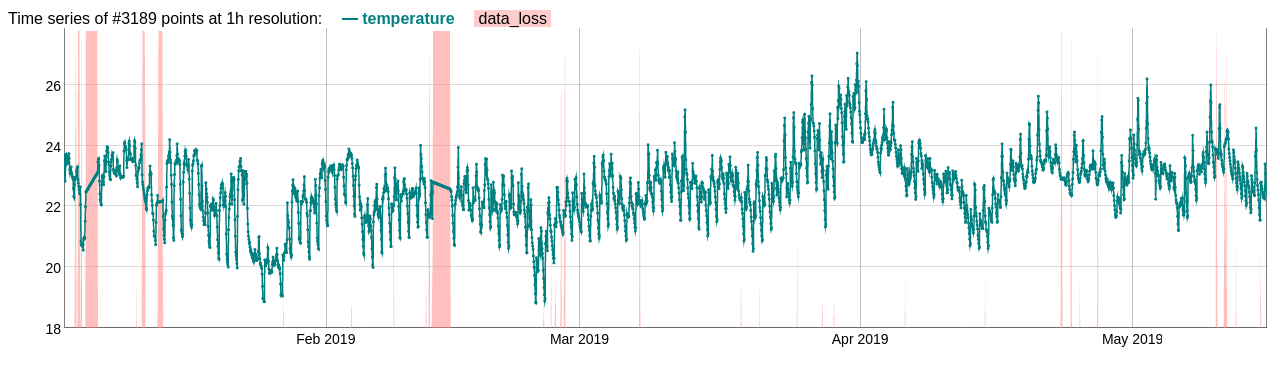

In [4]:
timeseries.plot()

Instantiate and fit the model

In [5]:
from timeseria.models import PeriodicAverageForecaster

forecaster = PeriodicAverageForecaster()
forecaster.fit(timeseries)

[INFO] timeseria.models.forecasters: Detected periodicity: 24x 1h
[INFO] timeseria.models.forecasters: Using a window of "24"


Call the `predict()` function of the model. This returns key-value data with the prediction values

In [6]:
timeseries_with_forecast = forecaster.apply(timeseries, steps=24*3)

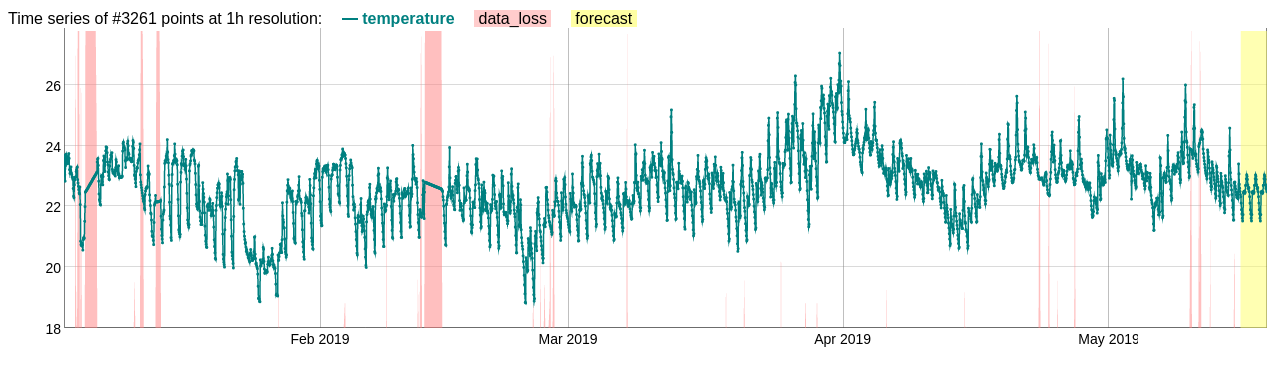

In [7]:
timeseries_with_forecast.plot()

Evaluate the forecaster. By default, window-based forecasters get evaluated on one step ahead and on a number of steps ahead equal to the window length, with RMSE and MAE metrics:

In [8]:
forecaster.evaluate(timeseries)

[INFO] timeseria.models.forecasters: Will evaluate model for [1, 24] steps ahead with metrics ['RMSE', 'MAE']


{'RMSE': 0.6187106383406303, 'MAE': 0.46844984996838346}

We can set custom steps ahedad and add or remove evalution metrics to the evaluation:

In [9]:
forecaster.evaluate(timeseries, steps=[1,2,3], metrics=['MAE', 'MAPE'])

[INFO] timeseria.models.forecasters: Will evaluate model for [1, 2, 3] steps ahead with metrics ['MAE', 'MAPE']


{'MAE': 0.40894241863588027, 'MAPE': 0.018088814494578456}

We can ask for the details when evaluating:

In [10]:
forecaster.evaluate(timeseries, steps=[1,2,3], metrics=['MAE', 'MAPE'], details=True)

[INFO] timeseria.models.forecasters: Will evaluate model for [1, 2, 3] steps ahead with metrics ['MAE', 'MAPE']


{'MAE_1_steps': 0.401049913670268,
 'MAPE_1_steps': 0.017737905360553242,
 'MAE_2_steps': 0.40913082876187573,
 'MAPE_2_steps': 0.018097067301057805,
 'MAE_3_steps': 0.416646513475497,
 'MAPE_3_steps': 0.018431470822124322,
 'MAE': 0.40894241863588027,
 'MAPE': 0.018088814494578456}

If evaluating for one step ahead only, we can also get back the evaluation time series

In [11]:
results = forecaster.evaluate(timeseries, steps=[1], metrics=['MAE', 'MAPE'], evaluation_series=True)

[INFO] timeseria.models.forecasters: Will evaluate model for [1] steps ahead with metrics ['MAE', 'MAPE']


In [12]:
results

{'MAE': 0.401049913670268,
 'MAPE': 0.017737905360553242,
 'evaluation_series': Time series of #3165 points at 1h resolution, from point @ 1546567200.0 (2019-01-04 02:00:00+00:00) to point @ 1557957600.0 (2019-05-15 22:00:00+00:00)}

...which we can then plot:

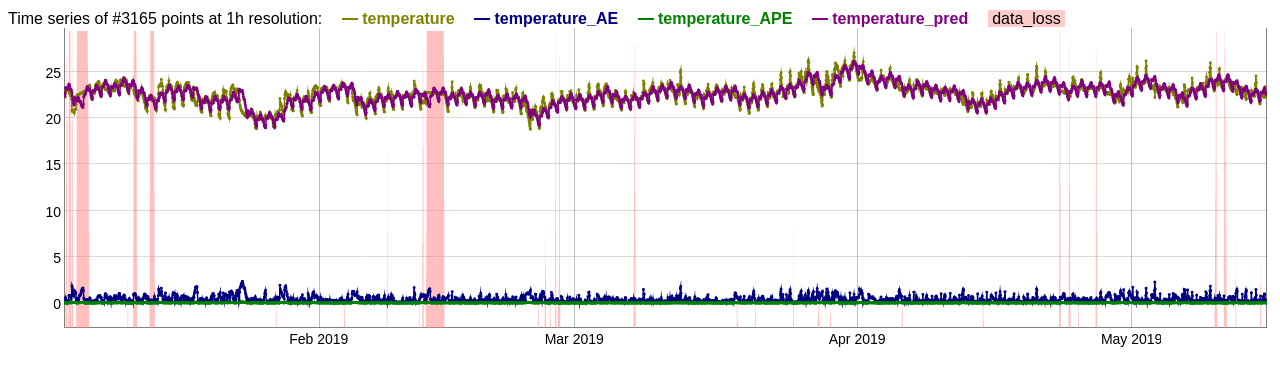

In [13]:
results['evaluation_series'].plot()

We can also directly plot the evaluation (for one step ahead) and remove any error metrics to visually inspect the predictions:

[INFO] timeseria.models.forecasters: Will evaluate model for [1] steps ahead with metrics []


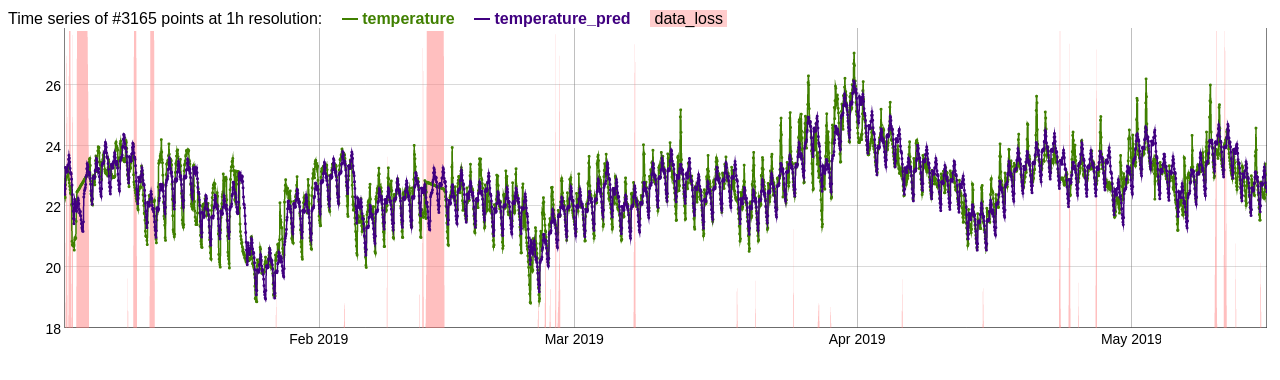

In [14]:
forecaster.evaluate(timeseries, steps=[1], metrics=None, plot=True)

Lastly, Timeseria also supports cross-validating the forecasting models:

In [15]:
forecaster = PeriodicAverageForecaster()
forecaster.cross_validate(timeseries, rounds=3, fit_periodicity=24)

[INFO] timeseria.models.base: Cross validation round 1/3: validate from 1546480800.0 (2019-01-03 02:00:00+00:00) to 1550307600.0 (2019-02-16 09:00:00+00:00), fit on the rest.
[INFO] timeseria.models.forecasters: Using a window of "24"
[INFO] timeseria.models.forecasters: Will evaluate model for [1, 24] steps ahead with metrics ['RMSE', 'MAE']
[INFO] timeseria.models.base: Cross validation round 2/3: validate from 1550307600.0 (2019-02-16 09:00:00+00:00) to 1554134400.0 (2019-04-01 16:00:00+00:00), fit on the rest.
[INFO] timeseria.models.forecasters: Using a window of "24"
[INFO] timeseria.models.forecasters: Will evaluate model for [1, 24] steps ahead with metrics ['RMSE', 'MAE']
[INFO] timeseria.models.base: Cross validation round 3/3: validate from 1554134400.0 (2019-04-01 16:00:00+00:00) to 1557957600.0 (2019-05-15 22:00:00+00:00), fit on the rest.
[INFO] timeseria.models.forecasters: Using a window of "24"
[INFO] timeseria.models.forecasters: Will evaluate model for [1, 24] steps 

{'RMSE_avg': 0.6663584033922387,
 'RMSE_stdev': 0.05789413501663828,
 'MAE_avg': 0.511379883493579,
 'MAE_stdev': 0.04413118524715239}

In the cross validation, we can pass arguments to the fit and evlauate calls by just prepending with a `fit_` or `evaluate_`:

In [16]:
forecaster = PeriodicAverageForecaster()
forecaster.cross_validate(timeseries, rounds=3, fit_periodicity=24, evaluate_metrics=['MAPE'], evaluate_steps=[1])

[INFO] timeseria.models.base: Cross validation round 1/3: validate from 1546480800.0 (2019-01-03 02:00:00+00:00) to 1550307600.0 (2019-02-16 09:00:00+00:00), fit on the rest.
[INFO] timeseria.models.forecasters: Using a window of "24"
[INFO] timeseria.models.forecasters: Will evaluate model for [1] steps ahead with metrics ['MAPE']
[INFO] timeseria.models.base: Cross validation round 2/3: validate from 1550307600.0 (2019-02-16 09:00:00+00:00) to 1554134400.0 (2019-04-01 16:00:00+00:00), fit on the rest.
[INFO] timeseria.models.forecasters: Using a window of "24"
[INFO] timeseria.models.forecasters: Will evaluate model for [1] steps ahead with metrics ['MAPE']
[INFO] timeseria.models.base: Cross validation round 3/3: validate from 1554134400.0 (2019-04-01 16:00:00+00:00) to 1557957600.0 (2019-05-15 22:00:00+00:00), fit on the rest.
[INFO] timeseria.models.forecasters: Using a window of "24"
[INFO] timeseria.models.forecasters: Will evaluate model for [1] steps ahead with metrics ['MAPE'

{'MAPE_avg': 0.01991170804887725, 'MAPE_stdev': 0.0018794528247418093}